# 🧠 Classification de Pneumonie avec Transfer Learning & MLflow


## 📝 Introduction

La pneumonie est une infection pulmonaire fréquente et potentiellement grave, dont le diagnostic repose souvent sur l’analyse d’images radiographiques thoraciques. L’interprétation de ces radios nécessite une expertise médicale et peut être sujette à des erreurs ou à des délais, notamment dans les contextes à ressources limitées.

Le problème abordé dans ce notebook est la classification automatique des images de radiographies thoraciques afin de détecter la présence ou l’absence de pneumonie. L’objectif est d’assister les professionnels de santé en proposant un outil d’aide au diagnostic rapide et fiable.

Pour répondre à ce défi, nous avons choisi d’utiliser le Transfer Learning. Cette approche consiste à exploiter des modèles de deep learning pré-entraînés sur de larges bases d’images (comme ImageNet), puis à les adapter à notre tâche spécifique de classification médicale. Le Transfer Learning permet d’obtenir de bonnes performances même avec un jeu de données médical limité, tout en réduisant le temps et les ressources nécessaires à l’entraînement.

Ce notebook a pour objectif de :
- Mettre en place un pipeline complet de classification d’images médicales (radiographies thoraciques) pour le diagnostic de la pneumonie.
- Comparer les performances de différents modèles pré-entraînés (MobileNetV2, ResNet50).
- Suivre et analyser les résultats à l’aide de MLflow pour une meilleure traçabilité des expériences.


## 📦 1. Imports et Paramètres

Dans cette section, nous importons toutes les librairies nécessaires pour la manipulation des données, la construction et l’entraînement des modèles de deep learning, ainsi que pour le suivi des expériences avec MLflow.  
Nous définissons également les paramètres globaux du projet (taille des images, batch size, nombre d’époques, etc.) afin d’assurer la reproductibilité des résultats.

In [1]:
import os  # Gestion des chemins et opérations système
import numpy as np  # Calcul numérique et manipulation de tableaux
import matplotlib.pyplot as plt  # Visualisation de données
import seaborn as sns  # Visualisation avancée/statistiques
import tensorflow as tf  # Deep learning
from tensorflow.keras import layers, models, applications  # Modules Keras pour la construction de modèles
from tensorflow.keras.callbacks import EarlyStopping  # Callback pour arrêter l'entraînement tôt
from sklearn.metrics import classification_report, confusion_matrix  # Évaluation des modèles
import mlflow  # Suivi des expériences ML
import mlflow.tensorflow  # Intégration MLflow avec TensorFlow
from collections import Counter

# Configuration de l'environnement MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # URI du serveur MLflow

# Configuration des paramètres globaux
sns.set_theme()  # Thème graphique par défaut pour seaborn
SEED: int = 42  # Graine pour la reproductibilité
tf.random.set_seed(SEED)  # Graine TensorFlow
np.random.seed(SEED)  # Graine NumPy

IMG_SIZE: int = 224  # Taille des images d'entrée
BATCH_SIZE: int = 32  # Taille des lots pour l'entraînement
EPOCHS: int = 10  # Nombre d'époques d'entraînement
DATA_DIR: str = "data/chest_xray"  # Chemin vers le dossier de données


## 🗂️ 2. Chargement des Données

Nous chargeons ici les images de radiographies thoraciques depuis les dossiers d’entraînement, de validation et de test.  
Chaque image est associée à un label indiquant la présence ou l’absence de pneumonie.  
Cette étape est cruciale pour préparer les données à l’entraînement des modèles.

In [2]:
# Chargement des datasets d'images depuis les dossiers, avec typage explicite

train_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED
)

val_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED
)

test_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED
)

# Récupération des noms de classes (ex: ['NORMAL', 'PNEUMONIA'])
class_names: list[str] = train_ds.class_names
print("Classes:", class_names)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


## 🔎 3. Exploration des données

Avant de lancer l’entraînement, il est important d’explorer le jeu de données pour :
- Visualiser quelques exemples de radiographies et leurs labels,
- Vérifier la répartition des classes (normal/pneumonie),
- S’assurer de la qualité et de la diversité des images.

Cette étape permet de mieux comprendre les défis de la tâche de classification et d’anticiper d’éventuels problèmes (déséquilibre, bruit, etc.).

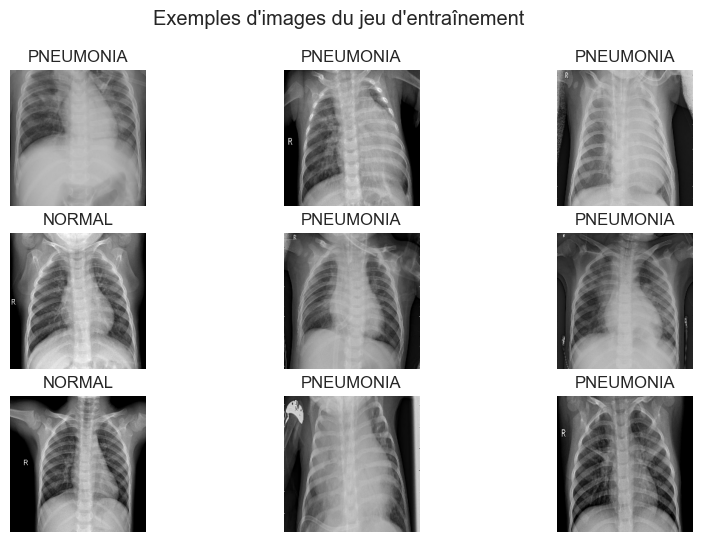

Train : 5216 images
  - NORMAL: 1341 images
  - PNEUMONIA: 3875 images
Val : 16 images
  - NORMAL: 8 images
  - PNEUMONIA: 8 images
Test : 624 images
  - NORMAL: 234 images
  - PNEUMONIA: 390 images


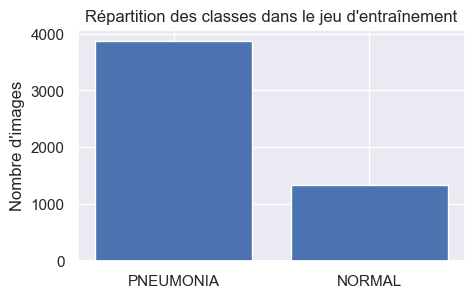

In [3]:
# Affichage de quelques images du jeu d'entraînement avec leurs labels
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Exemples d'images du jeu d'entraînement")
plt.show()

# Affichage du nombre d'images par split et par classe
def count_images_in_folder(folder_path: str) -> dict:
    """
    Compte le nombre d'images dans chaque sous-dossier (classe) d'un dossier donné.
    Args:
        folder_path: chemin du dossier (ex: data/chest_xray/train)
    Returns:
        Dictionnaire {classe: nombre d'images}
    """
    counts = {}
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

splits = ['train', 'val', 'test']
for split in splits:
    split_path = os.path.join(DATA_DIR, split)
    counts = count_images_in_folder(split_path)
    total = sum(counts.values())
    print(f"{split.capitalize()} : {total} images")
    for cls, n in counts.items():
        print(f"  - {cls}: {n} images")

# Répartition des classes dans le jeu d'entraînement

all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())
class_counts = Counter(all_labels)
plt.figure(figsize=(5,3))
plt.bar([class_names[i] for i in class_counts.keys()], class_counts.values())
plt.title("Répartition des classes dans le jeu d'entraînement")
plt.ylabel("Nombre d'images")
plt.show()

## 🧪 4. Prétraitement et préparation des données

Avant d’entraîner nos modèles, il est essentiel de préparer les données :
- **Normalisation** des images (pixels entre 0 et 1) pour faciliter l’apprentissage.
- **Préchargement asynchrone** pour accélérer l’entraînement.
- **Batching** automatique via les datasets TensorFlow.

Ces étapes garantissent que les images sont dans un format optimal pour le réseau de neurones.

In [4]:
def preprocess(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    """
    Normalise l'image (pixels entre 0 et 1) et retourne l'image et le label.
    Args:
        image: Image brute (tf.Tensor).
        label: Label associé (tf.Tensor).
    Returns:
        Tuple (image normalisée, label inchangé).
    """
    image = tf.cast(image, tf.float32) / 255.0  # Conversion en float32 et normalisation
    return image, label

# Application du prétraitement et préchargement asynchrone pour accélérer l'entraînement
train_ds: tf.data.Dataset = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds: tf.data.Dataset = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds: tf.data.Dataset = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)


## 🧠 5. Modélisation avec Transfer Learning

Nous exploitons ici la puissance du Transfer Learning en utilisant des modèles de CNN pré-entraînés (MobileNetV2, ResNet50, etc.) sur ImageNet.  
L’architecture est adaptée à notre tâche de classification binaire (pneumonie vs normal) :

- **Suppression de la tête du modèle pré-entraîné** (`include_top=False`)
- **Ajout d’un GlobalAveragePooling2D** pour réduire la dimensionnalité
- **Ajout d’un Dropout** pour limiter l’overfitting
- **Ajout d’une couche Dense** avec activation adaptée (`softmax` ou `sigmoid`)
- **Compilation** du modèle avec une loss et des métriques adaptées à la classification binaire

Nous allons maintenant construire et entraîner ces modèles.

In [5]:
def build_model(base_model: tf.keras.Model, num_classes: int) -> tf.keras.Model:
    """
    Construit un modèle de classification basé sur un modèle pré-entraîné (transfer learning).

    Args:
        base_model (tf.keras.Model): Le backbone pré-entraîné (ex: MobileNetV2, ResNet50) sans la couche de sortie.
        num_classes (int): Nombre de classes de sortie pour la classification.

    Returns:
        tf.keras.Model: Le modèle complet prêt à être compilé et entraîné.
    """
    # Entrée d'image de taille (IMG_SIZE, IMG_SIZE, 3)
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # Passage dans le modèle pré-entraîné sans entraîner ses poids
    x = base_model(inputs, training=False)
    # Pooling global pour réduire la dimensionnalité
    x = layers.GlobalAveragePooling2D()(x)
    # Dropout pour limiter l'overfitting
    x = layers.Dropout(0.3)(x)
    # Couche de sortie adaptée au nombre de classes (softmax pour classification multi-classes)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    # Création du modèle final
    return tf.keras.Model(inputs, outputs)


## 📉 6. Fonctions Utilitaires

Cette section regroupe des fonctions utilitaires pour visualiser les courbes d’apprentissage (loss et accuracy) et faciliter l’analyse des performances des modèles.

In [6]:
def plot_learning_curves(history: tf.keras.callbacks.History, save_path: str = None) -> None:
    """
    Affiche et sauvegarde les courbes d'apprentissage (loss et accuracy) pour l'entraînement et la validation.

    Args:
        history (tf.keras.callbacks.History): Objet History retourné par model.fit(), contenant les métriques d'entraînement.
        save_path (str, optionnel): Chemin où sauvegarder la figure. Si None, la figure n'est pas sauvegardée.

    Returns:
        None
    """
    plt.figure(figsize=(12, 5))  # Crée une figure de taille 12x5 pouces

    # Courbe de la perte (loss)
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1ère colonne
    plt.plot(history.history['loss'], label='Train Loss')  # Perte sur le train
    plt.plot(history.history['val_loss'], label='Val Loss')  # Perte sur la validation
    plt.legend()
    plt.title('Loss')

    # Courbe de l'accuracy
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème colonne
    plt.plot(history.history['accuracy'], label='Train Acc')  # Accuracy sur le train
    plt.plot(history.history['val_accuracy'], label='Val Acc')  # Accuracy sur la validation
    plt.legend()
    plt.title('Accuracy')

    # Sauvegarde la figure si un chemin est fourni
    if save_path:
        plt.savefig(save_path)
    plt.show()  # Affiche la figure à l'écran


## 📊 7. Entraînement et Log MLflow

Nous définissons ici la fonction d’entraînement des modèles, intégrée avec MLflow pour le suivi automatique des hyperparamètres, des métriques et des artefacts (courbes, rapports, matrices de confusion).  
Cela permet de garder une trace rigoureuse de toutes les expériences réalisées.

In [7]:
early_stop: EarlyStopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

def log_run(
    model: tf.keras.Model,
    model_name: str
) -> tf.keras.callbacks.History:
    """
    Entraîne un modèle, logue les résultats et artefacts avec MLflow, puis retourne l'historique d'entraînement.

    Args:
        model (tf.keras.Model): Modèle Keras à entraîner et logger.
        model_name (str): Nom du modèle (pour l'expérience MLflow).

    Returns:
        tf.keras.callbacks.History: Historique d'entraînement retourné par model.fit().
    """
    # Définit l'expérience MLflow (créée si elle n'existe pas)
    mlflow.set_experiment("Classification_Pneumonie")

    # Démarre un nouveau run MLflow
    with mlflow.start_run(run_name=f"{model_name}_run"):
        # Log des hyperparamètres
        mlflow.log_params({
            "model": model_name,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "img_size": IMG_SIZE,
            "learning_rate": model.optimizer.learning_rate.numpy(),
            "dropout_rate": 0.3
        })

        # Entraînement avec early stopping
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=[early_stop]
        )

        # Évaluation détaillée sur le test set
        y_true = []
        y_pred = []
        y_pred_proba = []
        
        for images, labels in test_ds:
            preds = model.predict(images)
            preds_labels = np.argmax(preds, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds_labels)
            y_pred_proba.extend(preds)

        # Log des métriques principales
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        
        # Métriques globales
        mlflow.log_metrics({
            "test_accuracy": report_dict['accuracy'],
            "test_macro_precision": report_dict['macro avg']['precision'],
            "test_macro_recall": report_dict['macro avg']['recall'],
            "test_macro_f1": report_dict['macro avg']['f1-score'],
            "test_weighted_precision": report_dict['weighted avg']['precision'],
            "test_weighted_recall": report_dict['weighted avg']['recall'],
            "test_weighted_f1": report_dict['weighted avg']['f1-score']
        })

        # Métriques par classe
        for class_name in class_names:
            mlflow.log_metrics({
                f"{class_name}_precision": report_dict[class_name]['precision'],
                f"{class_name}_recall": report_dict[class_name]['recall'],
                f"{class_name}_f1": report_dict[class_name]['f1-score'],
                f"{class_name}_support": report_dict[class_name]['support']
            })

        # Sauvegarde du modèle avec versioning
        mlflow.tensorflow.log_model(
            model,
            artifact_path="model",
            registered_model_name=f"{model_name}_pneumonia",
            signature=mlflow.models.infer_signature(
                test_ds.take(1).get_single_element()[0],
                model.predict(test_ds.take(1))
            )
        )

        # Sauvegarde des poids séparément
        weights_path = f"{model_name}_weights.h5"
        model.save_weights(weights_path)
        mlflow.log_artifact(weights_path)
        os.remove(weights_path)  # Nettoyage du fichier temporaire

        # Log des visualisations existantes
        plot_learning_curves(history, save_path="learning_curves.png")
        mlflow.log_artifact("learning_curves.png")
        os.remove("learning_curves.png")

        # Matrice de confusion avec pourcentages
        cm = confusion_matrix(y_true, y_pred)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        sns.heatmap(cm, annot=True, fmt='d', ax=ax1, cmap='Blues')
        ax1.set_xlabel('Prédictions')
        ax1.set_ylabel('Réel')
        ax1.set_title('Matrice de Confusion (nombres)')
        
        sns.heatmap(cm_percent, annot=True, fmt='.2%', ax=ax2, cmap='Blues')
        ax2.set_xlabel('Prédictions')
        ax2.set_ylabel('Réel')
        ax2.set_title('Matrice de Confusion (pourcentages)')
        
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()
        os.remove("confusion_matrix.png")

        return history


## 🧪 8. Entraînement du Modèle MobileNetV2

Nous entraînons ici un premier modèle basé sur MobileNetV2, un backbone léger et efficace pour la classification d’images.  
Nous évaluons ses performances sur le jeu de test et loguons tous les résultats avec MLflow.

### 🧪 Pourquoi commencer par MobileNetV2 ?

Nous commençons par MobileNetV2 car il s’agit d’un modèle léger, rapide à entraîner et peu gourmand en ressources.  
Son architecture est particulièrement adaptée aux contextes médicaux où la rapidité d’inférence et la possibilité de déployer sur des machines modestes sont importantes.  
L’objectif est d’obtenir une première référence de performance sur notre jeu de données médical, tout en limitant le risque de surapprentissage grâce au gel des poids du backbone pré-entraîné.

In [ ]:
# 1. Création du backbone MobileNetV2 pré-entraîné (sans la tête de classification)
mobilenet_base: tf.keras.Model = applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # Taille des images d'entrée
    include_top=False,                    # On retire la dernière couche (classification ImageNet)
    weights='imagenet'                    # On charge les poids pré-entraînés sur ImageNet
)
mobilenet_base.trainable = False  # On gèle les poids du backbone pour le transfer learning

# 2. Construction du modèle complet avec notre fonction générique
mobilenet_model: tf.keras.Model = build_model(mobilenet_base, len(class_names))

# 3. Compilation du modèle (définition de l'optimiseur, de la loss et des métriques)
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Optimiseur Adam avec un petit learning rate
    loss='sparse_categorical_crossentropy',                  # Loss adaptée à la classification multi-classes avec labels entiers
    metrics=['accuracy']                                     # On suit la métrique d'accuracy
)

# 4. Entraînement du modèle et log automatique avec MLflow
# Création d'un lot de données d'exemple avec la bonne forme pour l'inférence de signature
sample_data = tf.random.normal((1, IMG_SIZE, IMG_SIZE, 3))
history_mobilenet: tf.keras.callbacks.History = log_run(mobilenet_model, "MobileNetV2")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 665ms/step - accuracy: 0.6263 - loss: 0.7088 - val_accuracy: 0.6875 - val_loss: 0.4650
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 674ms/step - accuracy: 0.8200 - loss: 0.3808 - val_accuracy: 0.8125 - val_loss: 0.3967
Epoch 3/10
 76/163 ━━━━━━━━━━━━━━━━━━━━ 56s 647ms/step - accuracy: 0.8770 - loss: 0.2886

### 🔎 Analyse des résultats MobileNetV2

Après entraînement, nous analysons les métriques obtenues (accuracy, loss, matrice de confusion, rapport de classification).  
- **Points forts attendus** : Rapidité d’entraînement, bonnes performances sur des jeux de données de taille modérée, faible surcoût computationnel.
- **Limites potentielles** : Capacité de représentation plus faible que des modèles plus profonds, ce qui peut limiter la détection de motifs complexes dans les radiographies.

Nous observons notamment la capacité du modèle à distinguer les cas de pneumonie des cas normaux, ainsi que les éventuelles confusions entre classes.

## 🔁 9. Comparaison avec ResNet50 (ou autre)

Pour approfondir l’analyse, nous entraînons un second modèle basé sur ResNet50, une architecture plus profonde et puissante.  
L’objectif est de comparer les performances des deux modèles sur la même tâche et d’identifier le meilleur compromis entre précision et complexité.

### 🔁 Pourquoi tester ResNet50 ?

ResNet50 est une architecture plus profonde et puissante, capable de capturer des motifs visuels plus complexes grâce à ses nombreuses couches et à l’utilisation de connexions résiduelles.  
En l’entraînant sur le même jeu de données, nous cherchons à savoir si une architecture plus complexe permet d’améliorer la précision du diagnostic, au prix d’un temps de calcul plus important.  
Cette comparaison permet de choisir le meilleur compromis entre performance et coût pour une application clinique.

In [ ]:
# 1. Création du backbone ResNet50 pré-entraîné (sans la tête de classification)
resnet_base: tf.keras.Model = applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # Taille des images d'entrée (224x224x3)
    include_top=False,                    # On retire la dernière couche (classification ImageNet)
    weights='imagenet'                    # On charge les poids pré-entraînés sur ImageNet
)
resnet_base.trainable = False  # On gèle les poids du backbone pour le transfer learning

# 2. Construction du modèle complet avec notre fonction générique
resnet_model: tf.keras.Model = build_model(resnet_base, len(class_names))

# 3. Compilation du modèle (définition de l'optimiseur, de la loss et des métriques)
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Optimiseur Adam avec un petit learning rate
    loss='sparse_categorical_crossentropy',                  # Loss adaptée à la classification multi-classes avec labels entiers
    metrics=['accuracy']                                     # On suit la métrique d'accuracy
)

# 4. Entraînement du modèle et log automatique avec MLflow
history_resnet: tf.keras.callbacks.History = log_run(resnet_model, "ResNet50")


### 🔎 Analyse des résultats ResNet50

Nous analysons ici les performances du modèle ResNet50 sur le même jeu de test.  
- **Points forts attendus** : Meilleure capacité à généraliser sur des motifs complexes, potentiellement meilleure précision sur des cas difficiles.
- **Limites potentielles** : Risque de surapprentissage si le jeu de données est trop petit, temps d’entraînement et d’inférence plus longs.

Nous comparons les résultats obtenus avec ceux de MobileNetV2 pour évaluer l’apport réel de la profondeur du modèle.

## 📈 10. Analyse comparative et logique du projet

L’objectif de ce projet est de démontrer l’intérêt du Transfer Learning pour la classification d’images médicales, en particulier pour le diagnostic de la pneumonie à partir de radiographies thoraciques.

**Démarche suivie :**
1. **Préparation des données** : Nettoyage, normalisation et structuration des images pour garantir la qualité de l’apprentissage.
2. **Choix des modèles** : Sélection de deux architectures complémentaires (MobileNetV2 pour la légèreté, ResNet50 pour la profondeur).
3. **Entraînement et suivi** : Utilisation de MLflow pour tracer les expériences, sauvegarder les modèles et comparer objectivement les résultats.
4. **Analyse des performances** : Évaluation sur des métriques classiques (accuracy, loss, matrice de confusion, rapport de classification) et discussion des avantages/inconvénients de chaque approche.

**Comparaison des modèles :**
- Si MobileNetV2 offre des performances proches de ResNet50, il sera privilégié pour sa rapidité et sa simplicité de déploiement.
- Si ResNet50 surpasse nettement MobileNetV2, il pourra être retenu pour des contextes où la précision prime sur la rapidité.

**Perspectives :**
- Tester d’autres architectures (EfficientNet, DenseNet…)
- Affiner le prétraitement ou augmenter les données (data augmentation)
- Adapter le modèle à d’autres pathologies ou modalités d’imagerie

Ce projet met en avant une démarche reproductible, rigoureuse et adaptée aux contraintes du domaine médical.

# A FAIRE

2. Dépôt GitHub contenant :
a. Le notebook final
✅ À faire

Place bien le notebook dans la racine du dépôt.
b. Un dossier data vide (avec mention dans README de télécharger les données)
✅ À faire

Ajoute un dossier data vide dans le dépôt.
Ajoute un fichier .gitkeep ou un .gitignore dans data pour qu’il soit versionné même vide.

3. Un README.md avec :
a. Contexte du projet
✅ À inclure

Explique brièvement le but : classification de radiographies pour le diagnostic de la pneumonie.
b. Installation des dépendances
✅ À inclure

Liste les dépendances principales (TensorFlow, scikit-learn, MLflow, etc.)
Propose un pip install -r requirements.txt si tu as ce fichier.
c. Comment lancer le notebook
✅ À inclure

Indique comment ouvrir le notebook dans Jupyter ou VS Code.
d. Fonctionnement de MLflow (lien vers mlflow ui)
✅ À inclure

Explique comment lancer MLflow localement :
Précise l’URL d’accès (généralement http://localhost:5000).
e. Résultats et observations
✅ À inclure

Résume les principaux résultats (accuracy, f1, confusion matrix, etc.).
Ajoute quelques observations sur la comparaison des modèles.



Conclusion
Si tu ajoutes un README.md complet et un dossier data vide, tout sera conforme à la checklist.
Ton notebook est déjà bien structuré et prêt à être livré sur GitHub.
Besoin d’un exemple de README.md ?
Je peux t’en générer un adapté à ton projet si tu veux !